In [1]:
from pathlib import Path
import pickle
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns

In [19]:
SETTINGS = ['hkust-transformer-adam-lr28','hkust-transformer-adamw-lr28','hkust-transformer-sgd-lr28',
            'hkust-0shot','hkust-1epoch',
            'hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-decoder'
           ]
PRETRAIN_SUFFIXES = ['cross-test-hkust','cross-test-hkust-metabsz5','cross-test-hkust-metabsz1']
ALGOS = ['fomaml','multi']
#ACCENTS = ['canada','scotland','southatlandtic'] # meta-val
#ACCENTS = ['african','hongkong','singapore','indian','philippines'] #meta-test(cross)
#ACCENTS = ['canada','scotland','southatlandtic','african','hongkong','singapore','indian','philippines'] # meta-val + meta-test(cross)
#ACCENTS = ['australia','england','ireland','newzealand','us'] 
ACCENTS = ['australia','england','ireland','newzealand','us','canada','scotland','southatlandtic','african','hongkong','singapore','indian','philippines']

In [5]:
root_path = Path.cwd().joinpath('testing-logs','evaluation')

In [6]:
class Entry:
    def __init__(self, setting, pretrain_suffix, algo, accent,runs=0):
        self.setting = setting
        self.pretrain_suffix = pretrain_suffix
        self.algo = algo
        self.accent = accent
        self.runs = runs
        
        self.collect_info()
        
        
    def satisfy(self, attr, tgt):
        return getattr(self, attr) == tgt
    
    def collect_info(self):
        # dev_cer, dev_wer, eval_cer, eval_wer
        self.info = dict()
        for stat in ['dev_cer','dev_wer','eval_cer','eval_wer', 'best_step']:
            self.info[stat] = {'x':list(), 'y':list()}
            
        check_path = root_path.joinpath(self.setting, self.algo, self.pretrain_suffix)
        for step_path in check_path.iterdir():
            final_path = step_path.joinpath(self.accent, str(self.runs))
            step = int(step_path.name[4:])
            
            if not final_path.joinpath('greedy_decode','wer').exists():
                continue
               
            #if step//1000 > 200:
                    #continue
                
            with open(final_path.joinpath('best_cer'),'r') as f:
                dev_cer = float(f.read().strip().split(' ')[1])
                
                self.info['dev_cer']['x'].append(step//1000)
                self.info['dev_cer']['y'].append(dev_cer)
                
            with open(final_path.joinpath('best_wer'),'r') as f:
                foo = f.read().strip().split(' ')
                
                best_step = int(foo[0])
                #print(best_step)
                dev_wer = float(foo[1])
                
                self.info['best_step']['x'].append(step//1000)
                self.info['best_step']['y'].append(best_step)
                self.info['dev_wer']['x'].append(step//1000)
                self.info['dev_wer']['y'].append(dev_wer)
                
            with open(final_path.joinpath('greedy_decode','cer')) as f:
                eval_cer = float(f.read().strip())
                self.info['eval_cer']['x'].append(step//1000)
                self.info['eval_cer']['y'].append(eval_cer)
                
            with open(final_path.joinpath('greedy_decode','wer')) as f:
                eval_wer = float(f.read().strip())
                self.info['eval_wer']['x'].append(step//1000)
                self.info['eval_wer']['y'].append(eval_wer)

In [20]:
#entry = Entry(setting, pretrain_suffix, algo, accent)
#entry = Entry('hkust-transformer-sgd-lr28', 'cross-test-hkust-metabsz5', 'fomaml', 'southatlandtic')

entries = []
for setting in SETTINGS:
    for pretrain_suffix in PRETRAIN_SUFFIXES:
        for algo in ALGOS:
            for accent in ACCENTS:
                p = root_path.joinpath(setting, algo, pretrain_suffix)
                if p.exists():
                    #print(pretrain_suffix)
                    entries.append(Entry(setting,pretrain_suffix,algo, accent))
                    #print("=========================================================")

In [18]:
sns.set_style("darkgrid")
def plot_learning_curve(stat, criterias, accents=list(), legend='pretrain_suffix', is_er = False):

    plt.figure(figsize=(22, 4))
    NUM_FIGS = len(accents)
    best_ers = {}
    for accent_n, accent in enumerate(accents,1):
        
        ###########
        criterias['accent'] = accent
        #criterias = {'setting': setting, 'accent': accent}
        ###########
        
        target_entries = list()

        for entry in entries:
            ok = True
            for attr, tgt in criterias.items():
                if isinstance(tgt, list):
                    check = any([entry.satisfy(attr,t) for t in tgt])
                else:
                    check = entry.satisfy(attr, tgt)

                if not check:
                    ok = False
                    break
            if ok:
                target_entries.append(entry)

        plt.subplot(1, NUM_FIGS, accent_n)
        
        plot_infos = {getattr(entry, legend): entry.info[stat] for entry in target_entries}
        
        for label_legend, plot_info in plot_infos.items():
            best_ers[label_legend] = min(plot_info['y'])
            sns.lineplot(x = plot_info['x'], y = plot_info['y'],label=label_legend,markers=True)
        plt.title("Adaptation on " +  r"$\bf{" + accent + "}$ " + stat)
        plt.xlabel("Pretraining step (x1000)")
        plt.ylabel(stat)
        
        if is_er:
            print(accent)
            for label_legend, min_er in best_ers.items():
                print(f"{label_legend}: {min_er}")
            

## Choose Optimizer

### multi

canada
hkust-transformer-adam-lr28: 41.9
hkust-transformer-adamw-lr28: 36.5
hkust-transformer-sgd-lr28: 35.1
scotland
hkust-transformer-adam-lr28: 56.7
hkust-transformer-adamw-lr28: 53.4
hkust-transformer-sgd-lr28: 51.1
southatlandtic
hkust-transformer-adam-lr28: 69.5
hkust-transformer-adamw-lr28: 60.3
hkust-transformer-sgd-lr28: 57.6


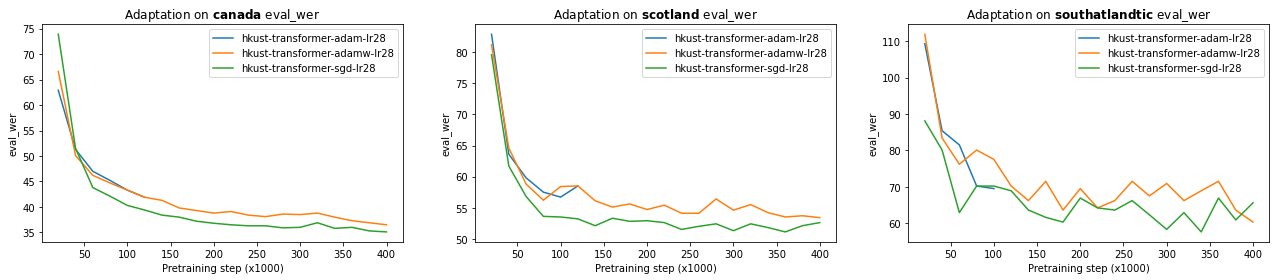

In [23]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-adam-lr28','hkust-transformer-adamw-lr28','hkust-transformer-sgd-lr28'],'pretrain_suffix': 'cross-test-hkust'},['canada','scotland','southatlandtic'],'setting',is_er=True)

canada
hkust-transformer-adam-lr28: 1
hkust-transformer-adamw-lr28: 1
hkust-transformer-sgd-lr28: 4651
scotland
hkust-transformer-adam-lr28: 1
hkust-transformer-adamw-lr28: 1
hkust-transformer-sgd-lr28: 2570
southatlandtic
hkust-transformer-adam-lr28: 161
hkust-transformer-adamw-lr28: 1
hkust-transformer-sgd-lr28: 81


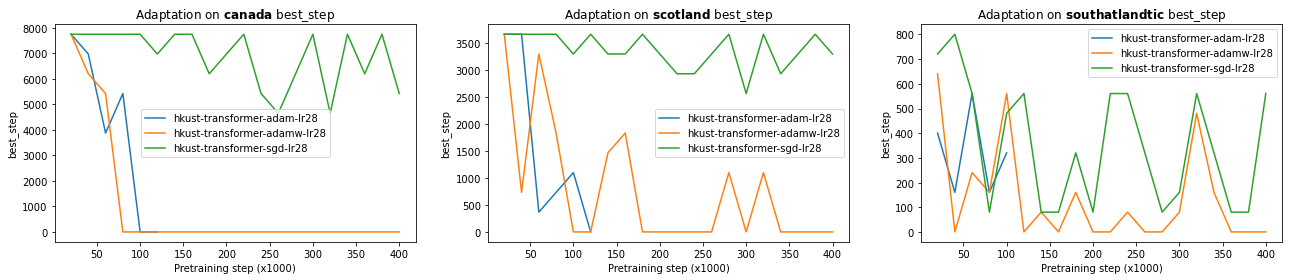

In [24]:
plot_learning_curve('best_step', {'setting':['hkust-transformer-adam-lr28','hkust-transformer-adamw-lr28','hkust-transformer-sgd-lr28'],'pretrain_suffix': 'cross-test-hkust'},D,'setting')

### fomaml (meta batch size 1)

canada
hkust-transformer-adam-lr28: 39.6
hkust-transformer-adamw-lr28: 39.6
hkust-transformer-sgd-lr28: 34.5
scotland
hkust-transformer-adam-lr28: 55.3
hkust-transformer-adamw-lr28: 55.3
hkust-transformer-sgd-lr28: 49.6
southatlandtic
hkust-transformer-adam-lr28: 58.3
hkust-transformer-adamw-lr28: 58.3
hkust-transformer-sgd-lr28: 55.0


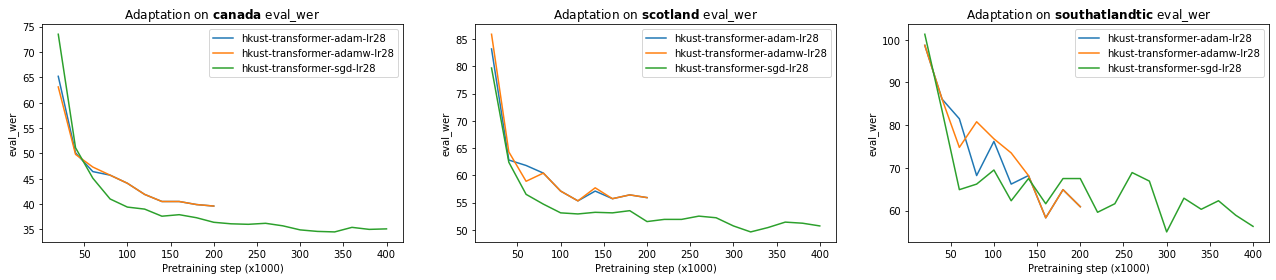

In [26]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-adam-lr28','hkust-transformer-adamw-lr28','hkust-transformer-sgd-lr28'],'pretrain_suffix': 'cross-test-hkust-metabsz1'},['canada','scotland','southatlandtic'],'setting',is_er=True)

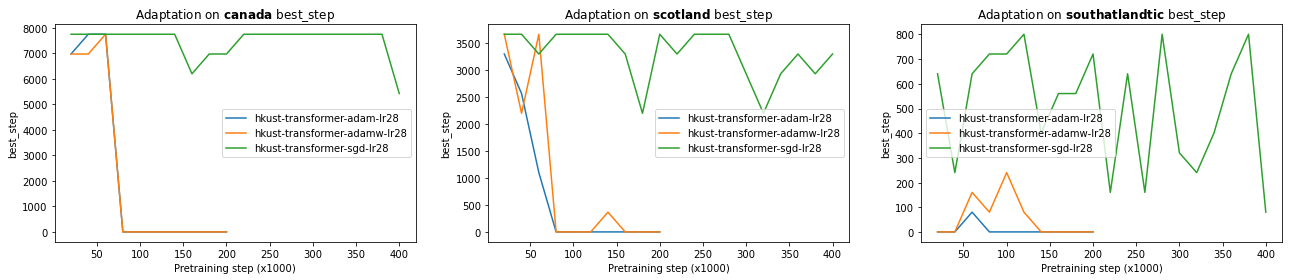

In [15]:
plot_learning_curve('best_step', {'setting':['hkust-transformer-adam-lr28','hkust-transformer-adamw-lr28','hkust-transformer-sgd-lr28'],'pretrain_suffix': 'cross-test-hkust-metabsz1'},['canada','scotland','southatlandtic'],'setting')

### fomaml (meta batch size 5)

canada
hkust-transformer-adam-lr28: 36.2
hkust-transformer-adamw-lr28: 36.2
hkust-transformer-sgd-lr28: 34.0
scotland
hkust-transformer-adam-lr28: 52.9
hkust-transformer-adamw-lr28: 52.9
hkust-transformer-sgd-lr28: 50.8
southatlandtic
hkust-transformer-adam-lr28: 58.3
hkust-transformer-adamw-lr28: 58.3
hkust-transformer-sgd-lr28: 55.0


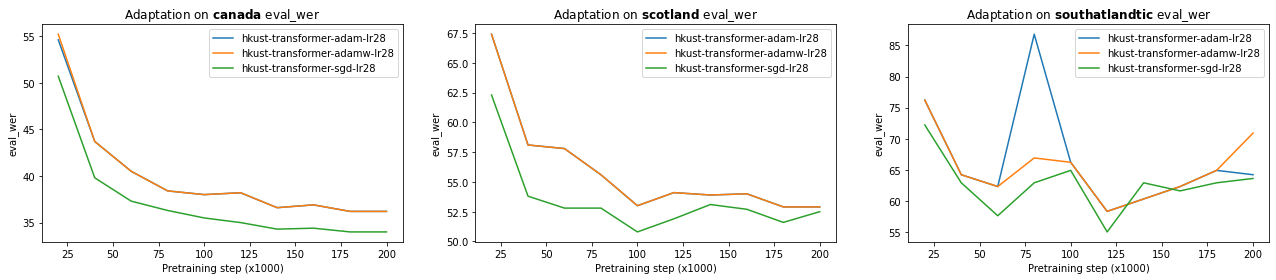

In [27]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-adam-lr28','hkust-transformer-adamw-lr28','hkust-transformer-sgd-lr28'],'pretrain_suffix': 'cross-test-hkust-metabsz5'},['canada','scotland','southatlandtic'],'setting',is_er=True)

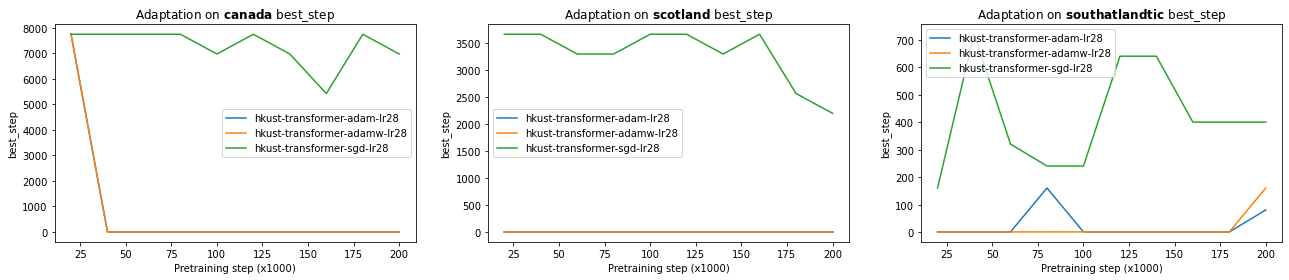

In [17]:
plot_learning_curve('best_step', {'setting':['hkust-transformer-adam-lr28','hkust-transformer-adamw-lr28','hkust-transformer-sgd-lr28'],'pretrain_suffix': 'cross-test-hkust-metabsz5'},['canada','scotland','southatlandtic'],'setting')

---

## Compare different algo under sgd-full-adapt setting

### Meta-val

canada
cross-test-hkust: 35.1
cross-test-hkust-metabsz5: 34.0
cross-test-hkust-metabsz1: 34.5
scotland
cross-test-hkust: 51.1
cross-test-hkust-metabsz5: 50.8
cross-test-hkust-metabsz1: 49.6
southatlandtic
cross-test-hkust: 57.6
cross-test-hkust-metabsz5: 55.0
cross-test-hkust-metabsz1: 55.0


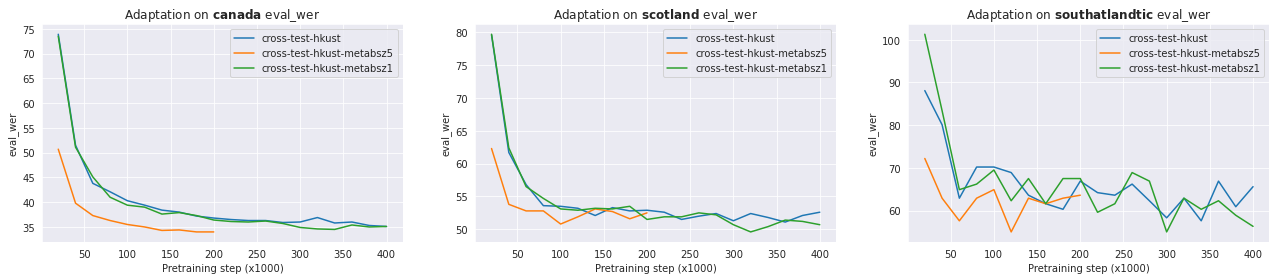

In [24]:
plot_learning_curve('eval_wer', {'setting':'hkust-transformer-sgd-lr28'},['canada','scotland','southatlandtic'],'pretrain_suffix',is_er=True)

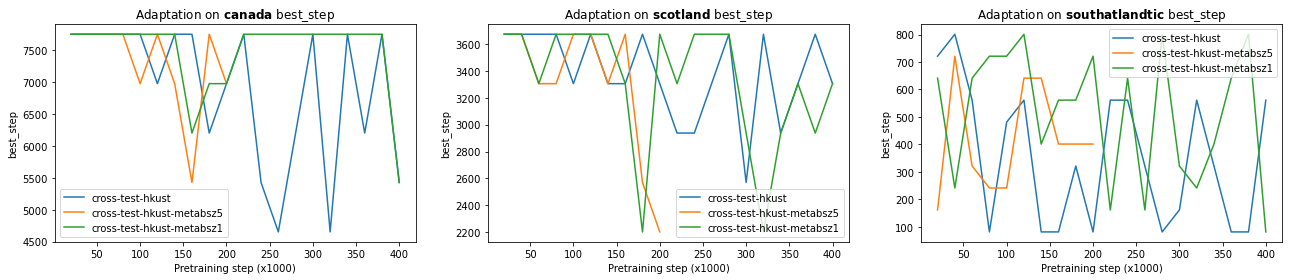

In [32]:
plot_learning_curve('best_step', {'setting':'hkust-transformer-sgd-lr28'},['canada','scotland','southatlandtic'],'pretrain_suffix')

### Meta-test

african
cross-test-hkust: 42.1
cross-test-hkust-metabsz5: 42.6
cross-test-hkust-metabsz1: 41.1
hongkong
cross-test-hkust: 47.2
cross-test-hkust-metabsz5: 49.1
cross-test-hkust-metabsz1: 47.6
singapore
cross-test-hkust: 50.1
cross-test-hkust-metabsz5: 51.3
cross-test-hkust-metabsz1: 50.9
indian
cross-test-hkust: 55.5
cross-test-hkust-metabsz5: 54.5
cross-test-hkust-metabsz1: 55.2
philippines
cross-test-hkust: 49.4
cross-test-hkust-metabsz5: 47.1
cross-test-hkust-metabsz1: 50.2


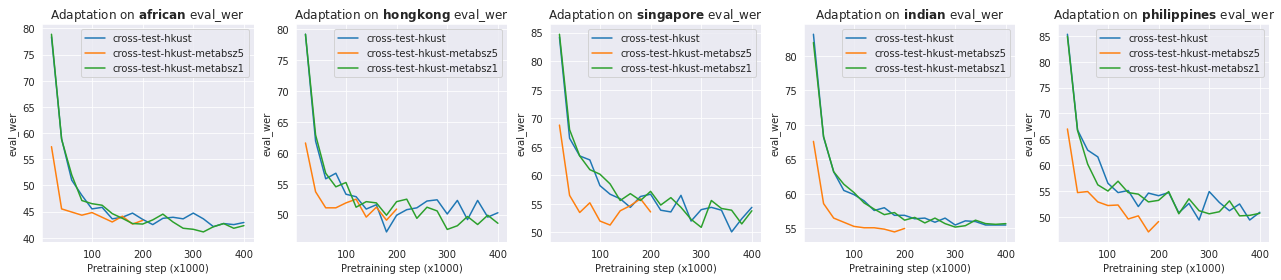

In [25]:
plot_learning_curve('eval_wer', {'setting':'hkust-transformer-sgd-lr28'},['african','hongkong','singapore','indian','philippines'],'pretrain_suffix',is_er=True)

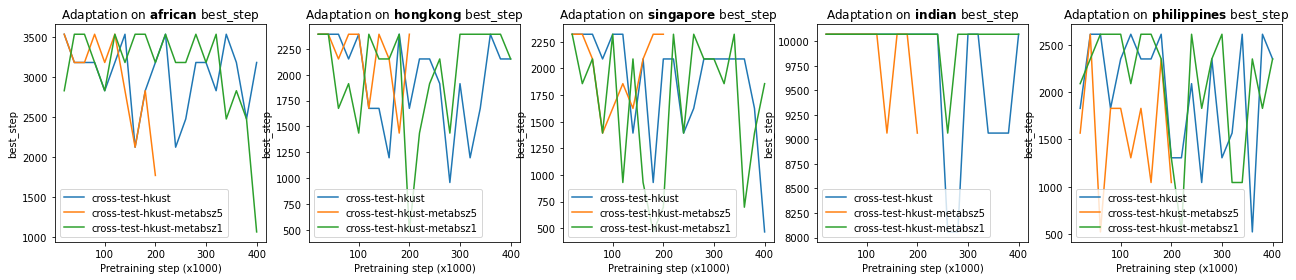

In [33]:
plot_learning_curve('best_step', {'setting':'hkust-transformer-sgd-lr28'},['african','hongkong','singapore','indian','philippines'],'pretrain_suffix')

---

## Freeze different parts of model

### Meta-val

**multi**

canada
hkust-transformer-sgd-lr28: 35.1
hkust-0shot: 36.5
hkust-transformer-sgd-freeze-ext: 36.4
hkust-transformer-sgd-freeze-encoder: 37.5
hkust-transformer-sgd-freeze-decoder: 39.5
scotland
hkust-transformer-sgd-lr28: 51.1
hkust-0shot: 53.4
hkust-transformer-sgd-freeze-ext: 52.1
hkust-transformer-sgd-freeze-encoder: 53.2
hkust-transformer-sgd-freeze-decoder: 55.8
southatlandtic
hkust-transformer-sgd-lr28: 57.6
hkust-0shot: 59.6
hkust-transformer-sgd-freeze-ext: 58.9
hkust-transformer-sgd-freeze-encoder: 62.9
hkust-transformer-sgd-freeze-decoder: 68.2


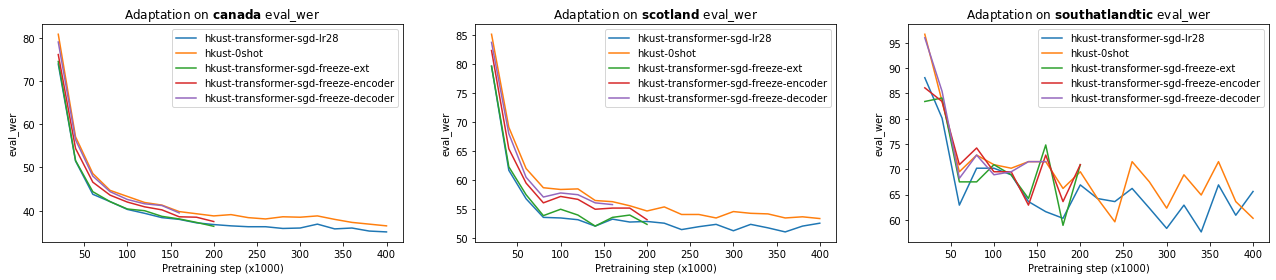

In [12]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust'},['canada','scotland','southatlandtic'],'setting',is_er=True)

**fomaml (meta bsz=1)**

canada
hkust-transformer-sgd-lr28: 34.5
hkust-0shot: 36.5
hkust-transformer-sgd-freeze-ext: 34.5
hkust-transformer-sgd-freeze-encoder: 35.8
hkust-transformer-sgd-freeze-decoder: 36.6
scotland
hkust-transformer-sgd-lr28: 49.6
hkust-0shot: 52.2
hkust-transformer-sgd-freeze-ext: 51.0
hkust-transformer-sgd-freeze-encoder: 51.4
hkust-transformer-sgd-freeze-decoder: 51.3
southatlandtic
hkust-transformer-sgd-lr28: 55.0
hkust-0shot: 54.3
hkust-transformer-sgd-freeze-ext: 56.3
hkust-transformer-sgd-freeze-encoder: 56.3
hkust-transformer-sgd-freeze-decoder: 57.0


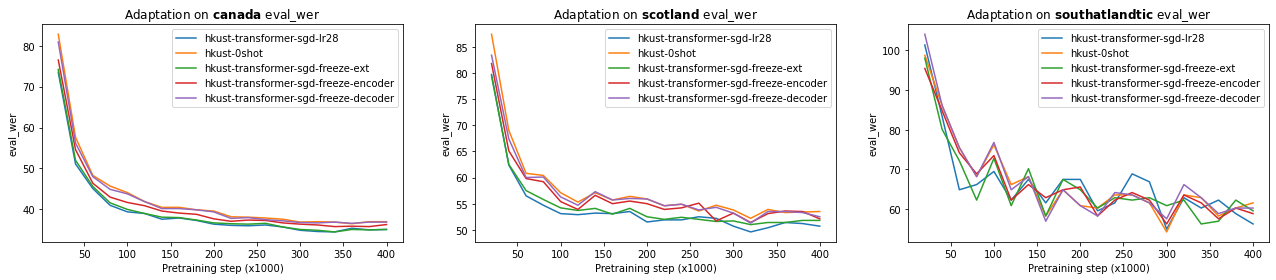

In [14]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust-metabsz1'},['canada','scotland','southatlandtic'],'setting',is_er=True)

**fomaml (meta bsz=5)**

canada
hkust-transformer-sgd-lr28: 34.0
hkust-0shot: 36.2
hkust-transformer-sgd-freeze-ext: 34.4
hkust-transformer-sgd-freeze-decoder: 36.1
scotland
hkust-transformer-sgd-lr28: 50.8
hkust-0shot: 52.9
hkust-transformer-sgd-freeze-ext: 50.7
hkust-transformer-sgd-freeze-decoder: 52.5
southatlandtic
hkust-transformer-sgd-lr28: 55.0
hkust-0shot: 58.3
hkust-transformer-sgd-freeze-ext: 51.7
hkust-transformer-sgd-freeze-decoder: 58.3


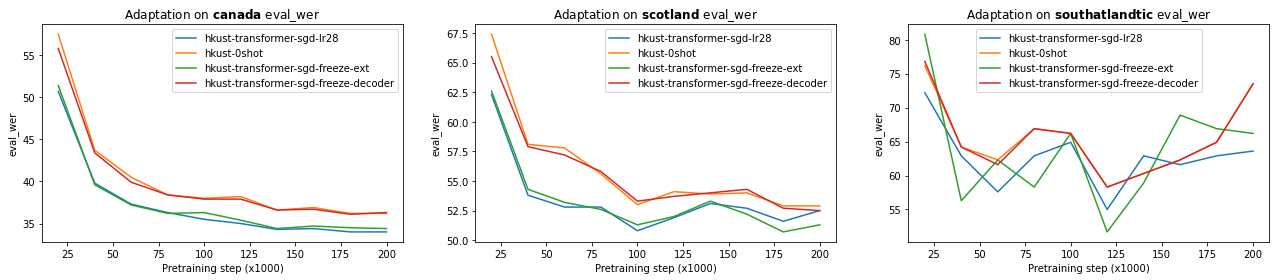

In [9]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust-metabsz5'},['canada','scotland','southatlandtic'],'setting',is_er=True)

### Meta-test

**multi**

african
hkust-transformer-sgd-lr28: 42.1
hkust-0shot: 44.1
hkust-transformer-sgd-freeze-ext: 44.0
hkust-transformer-sgd-freeze-encoder: 44.6
hkust-transformer-sgd-freeze-decoder: 46.9
hongkong
hkust-transformer-sgd-lr28: 47.2
hkust-0shot: 49.0
hkust-transformer-sgd-freeze-ext: 47.7
hkust-transformer-sgd-freeze-encoder: 48.3
hkust-transformer-sgd-freeze-decoder: 50.6
singapore
hkust-transformer-sgd-lr28: 50.1
hkust-0shot: 54.5
hkust-transformer-sgd-freeze-ext: 54.9
hkust-transformer-sgd-freeze-encoder: 56.8
hkust-transformer-sgd-freeze-decoder: 59.7
indian
hkust-transformer-sgd-lr28: 55.5
hkust-0shot: 63.3
hkust-transformer-sgd-freeze-ext: 57.2
hkust-transformer-sgd-freeze-encoder: 62.1
hkust-transformer-sgd-freeze-decoder: 65.4
philippines
hkust-transformer-sgd-lr28: 49.4
hkust-0shot: 53.3
hkust-transformer-sgd-freeze-ext: 54.2
hkust-transformer-sgd-freeze-encoder: 56.2
hkust-transformer-sgd-freeze-decoder: 58.1


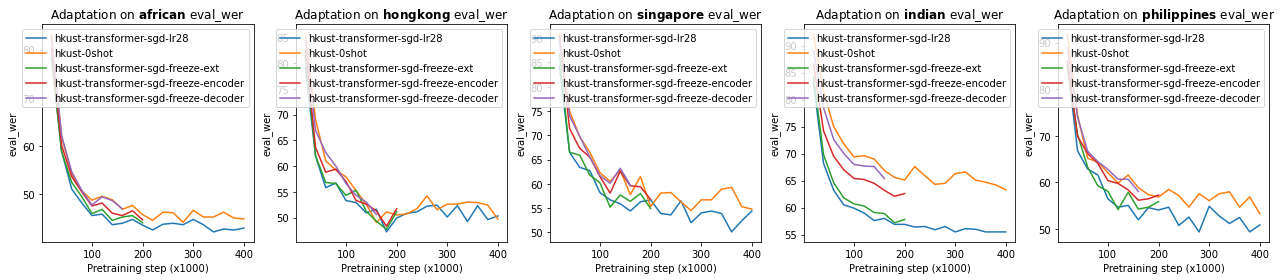

In [16]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust'},['african','hongkong','singapore','indian','philippines'],'setting',is_er=True)

**fomaml (meta bsz=1)**

african
hkust-transformer-sgd-lr28: 41.1
hkust-0shot: 42.5
hkust-transformer-sgd-freeze-ext: 40.5
hkust-transformer-sgd-freeze-encoder: 41.2
hkust-transformer-sgd-freeze-decoder: 42.6
hongkong
hkust-transformer-sgd-lr28: 47.6
hkust-0shot: 49.8
hkust-transformer-sgd-freeze-ext: 47.7
hkust-transformer-sgd-freeze-encoder: 47.2
hkust-transformer-sgd-freeze-decoder: 49.1
singapore
hkust-transformer-sgd-lr28: 50.9
hkust-0shot: 53.8
hkust-transformer-sgd-freeze-ext: 49.3
hkust-transformer-sgd-freeze-encoder: 53.0
hkust-transformer-sgd-freeze-decoder: 53.8
indian
hkust-transformer-sgd-lr28: 55.2
hkust-0shot: 64.1
hkust-transformer-sgd-freeze-ext: 56.7
hkust-transformer-sgd-freeze-encoder: 61.2
hkust-transformer-sgd-freeze-decoder: 63.3
philippines
hkust-transformer-sgd-lr28: 50.2
hkust-0shot: 52.7
hkust-transformer-sgd-freeze-ext: 50.3
hkust-transformer-sgd-freeze-encoder: 52.1
hkust-transformer-sgd-freeze-decoder: 53.2


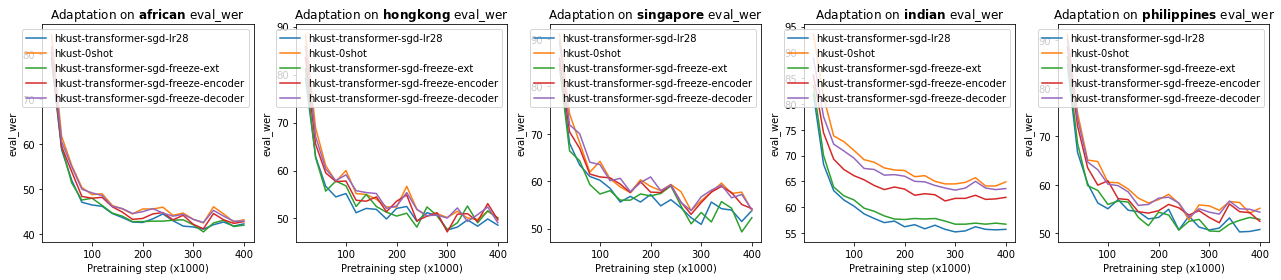

In [17]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust-metabsz1'},['african','hongkong','singapore','indian','philippines'],'setting',is_er=True)

**fomaml (meta bsz=5)**

african
hkust-transformer-sgd-lr28: 42.6
hkust-0shot: 43.9
hkust-transformer-sgd-freeze-ext: 42.0
hkust-transformer-sgd-freeze-decoder: 43.6
hongkong
hkust-transformer-sgd-lr28: 49.1
hkust-0shot: 48.7
hkust-transformer-sgd-freeze-ext: 49.3
hkust-transformer-sgd-freeze-decoder: 48.7
singapore
hkust-transformer-sgd-lr28: 51.3
hkust-0shot: 54.5
hkust-transformer-sgd-freeze-ext: 50.9
hkust-transformer-sgd-freeze-decoder: 54.5
indian
hkust-transformer-sgd-lr28: 54.5
hkust-0shot: 63.2
hkust-transformer-sgd-freeze-ext: 55.9
hkust-transformer-sgd-freeze-decoder: 62.8
philippines
hkust-transformer-sgd-lr28: 47.1
hkust-0shot: 53.1
hkust-transformer-sgd-freeze-ext: 48.8
hkust-transformer-sgd-freeze-decoder: 53.1


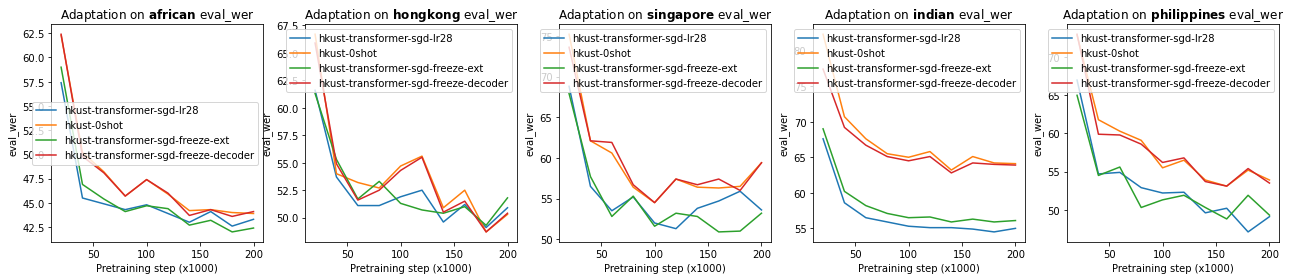

In [10]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust-metabsz5'},['african','hongkong','singapore','indian','philippines'],'setting',is_er=True)

### 0-shot

canada
cross-test-hkust: 36.5
cross-test-hkust-metabsz5: 36.2
cross-test-hkust-metabsz1: 36.5
scotland
cross-test-hkust: 53.4
cross-test-hkust-metabsz5: 52.9
cross-test-hkust-metabsz1: 52.2
southatlandtic
cross-test-hkust: 59.6
cross-test-hkust-metabsz5: 58.3
cross-test-hkust-metabsz1: 54.3


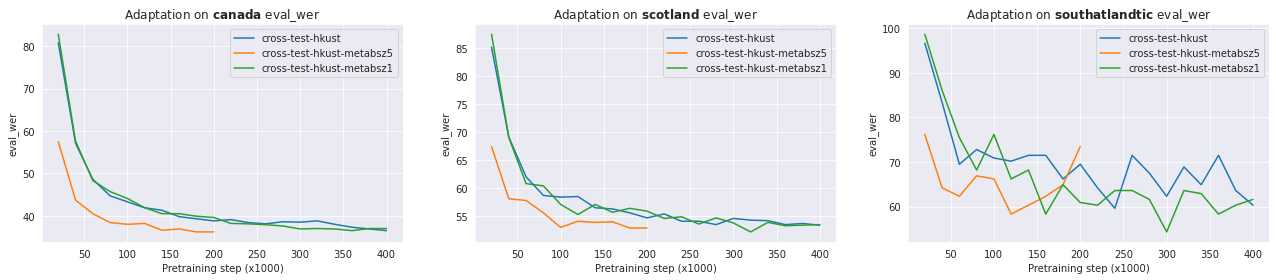

In [27]:
#meta-val
plot_learning_curve('eval_wer', {'setting':'hkust-0shot'},['canada','scotland','southatlandtic'],'pretrain_suffix',is_er=True)

african
cross-test-hkust: 44.1
cross-test-hkust-metabsz5: 43.9
cross-test-hkust-metabsz1: 42.5
hongkong
cross-test-hkust: 49.0
cross-test-hkust-metabsz5: 48.7
cross-test-hkust-metabsz1: 49.8
singapore
cross-test-hkust: 54.5
cross-test-hkust-metabsz5: 54.5
cross-test-hkust-metabsz1: 53.8
indian
cross-test-hkust: 63.3
cross-test-hkust-metabsz5: 63.2
cross-test-hkust-metabsz1: 64.1
philippines
cross-test-hkust: 53.3
cross-test-hkust-metabsz5: 53.1
cross-test-hkust-metabsz1: 52.7


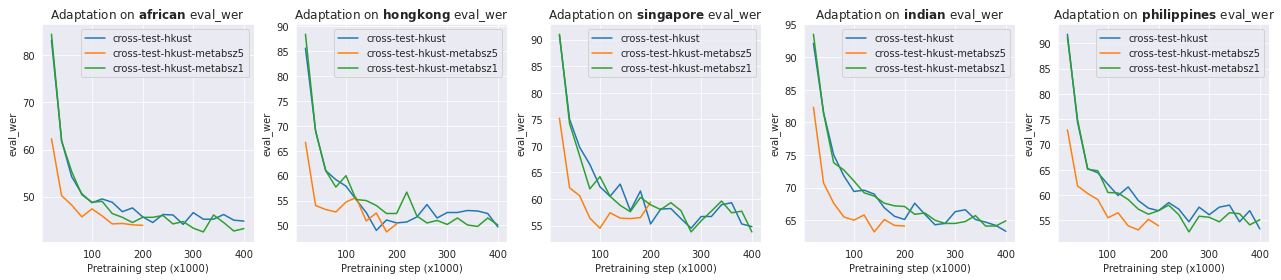

In [28]:
#meta-test
plot_learning_curve('eval_wer', {'setting':'hkust-0shot'},['african','hongkong','singapore','indian','philippines'],'pretrain_suffix',is_er=True)

### Adapt for 1epoch

australia
cross-test-hkust: 43.1
cross-test-hkust-metabsz5: 42.6
cross-test-hkust-metabsz1: 43.3
england
cross-test-hkust: 38.8
cross-test-hkust-metabsz5: 38.6
cross-test-hkust-metabsz1: 38.5
ireland
cross-test-hkust: 39.6
cross-test-hkust-metabsz5: 40.3
cross-test-hkust-metabsz1: 39.7
newzealand
cross-test-hkust: 35.7
cross-test-hkust-metabsz5: 36.3
cross-test-hkust-metabsz1: 36.4
us
cross-test-hkust: 37.9
cross-test-hkust-metabsz5: 37.2
cross-test-hkust-metabsz1: 38.0


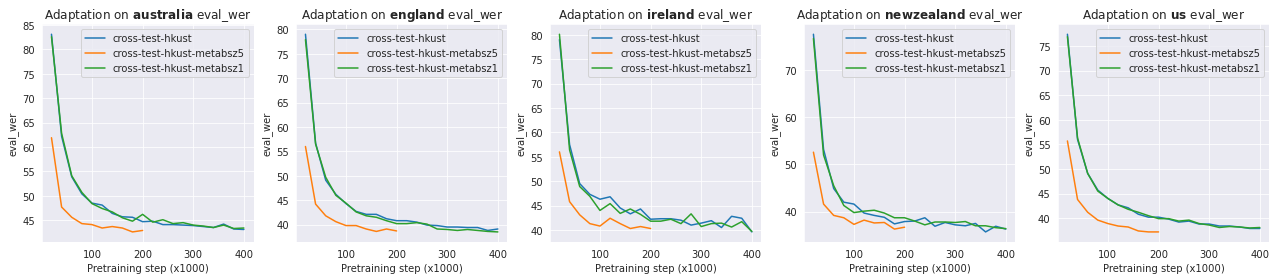

In [21]:
## Meta-train
plot_learning_curve('eval_wer', {'setting':'hkust-1epoch'},['australia','england','ireland','newzealand','us'],'pretrain_suffix',is_er=True)

canada
cross-test-hkust: 35.8
cross-test-hkust-metabsz5: 34.8
cross-test-hkust-metabsz1: 35.6
scotland
cross-test-hkust: 53.0
cross-test-hkust-metabsz5: 51.7
cross-test-hkust-metabsz1: 52.1
southatlandtic
cross-test-hkust: 57.6
cross-test-hkust-metabsz5: 57.0
cross-test-hkust-metabsz1: 54.3


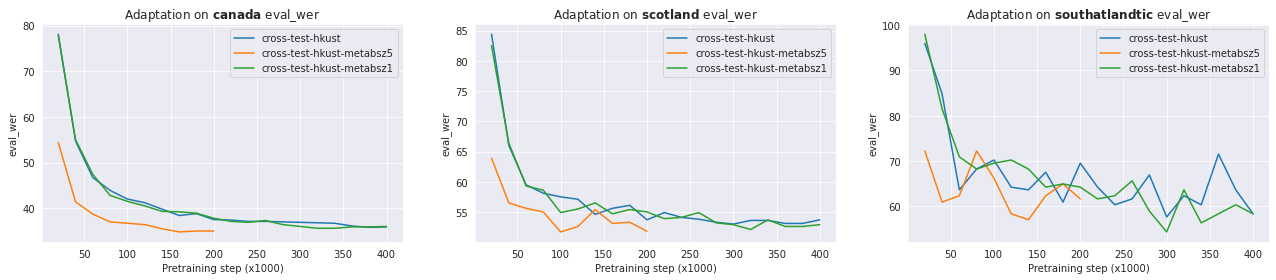

In [22]:
## Meta-val
plot_learning_curve('eval_wer', {'setting':'hkust-1epoch'},['canada','scotland','southatlandtic'],'pretrain_suffix',is_er=True)

african
cross-test-hkust: 43.6
cross-test-hkust-metabsz5: 42.9
cross-test-hkust-metabsz1: 41.8
hongkong
cross-test-hkust: 49.0
cross-test-hkust-metabsz5: 47.7
cross-test-hkust-metabsz1: 50.5
singapore
cross-test-hkust: 53.9
cross-test-hkust-metabsz5: 51.4
cross-test-hkust-metabsz1: 50.5
indian
cross-test-hkust: 59.5
cross-test-hkust-metabsz5: 59.3
cross-test-hkust-metabsz1: 59.6
philippines
cross-test-hkust: 52.2
cross-test-hkust-metabsz5: 50.4
cross-test-hkust-metabsz1: 51.9


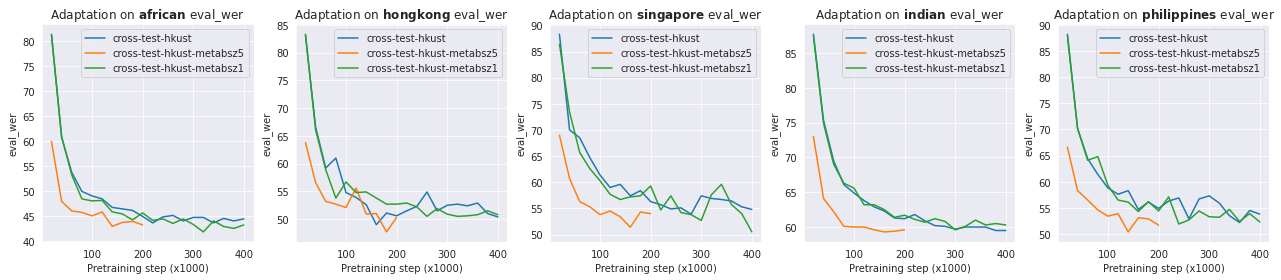

In [23]:
## Meta-test
plot_learning_curve('eval_wer', {'setting':'hkust-1epoch'},['african','hongkong','singapore','indian','philippines'],'pretrain_suffix',is_er=True)

---